## Extending the model

When the model is extended to include exogenous variables, it becomes a VARX model. Exogenous variables are external inputs to the system whose values are determined outside the model. They are used to explain or predict the behavior of the endogenous variables but are not themselves influenced by the system's internal dynamics. Including exogenous variables allows the model to account for the impact of known external factors, improving predictive performance and interpretability when such influences are present.

Examples of exogenous variables:

* Process set points
* Price forecasts
* Macro economic policies

A VARX model can be expressed as a system of equations:

$$
Y_t = \mu + \sum_{i=1}^{p} A_i Y_{t-i} + \sum_{j=0}^{s} B_j X_{t-j} + \epsilon_t
$$

Where:
* $Y_t$ is the vector of endogenous variables at time $t$,
* $X_t$ is the vector of exogenous variables at time $t$,
* $\mu$ is a vector of constants (intercepts),
* $A_i$ is a matrix of coefficients for the endogenous lags,
* $B_j$ is a matrix of coefficients for the exogenous lags,
* $p$ is the number of lags of endogenous variables
* $s$ is the number of lags of exogenous variables
* $\epsilon_t$ is a vector of error terms (shocks or innovations) at time $t$

## Example: Time Series Forecasting of Key Macroeconomic Indicators with Exogenous Variables

To evaluate the concept, we construct a model to examine how fluctuations in interest rates impact other macroeconomic indicators over time. We will build a time series forecasting model that predicts the future values of several endogenous macroeconomic indicators using a known exogenous policy variable.

### Endogenous Variables
These are the key macroeconomic indicators we aim to forecast:

* **Inflation Rate (%)** Reflects the rate at which prices are increasing. Central banks aim to control this through monetary policy.
* **GDP Growth Rate (%)** Represents the pace at which the economy is expanding or contracting.
* **Unemployment Rate (%)** Indicates the percentage of the labor force that is jobless but actively seeking employment.

### Exogenous Variables
These variables are treated as external to the system of interest. They are known drivers of macroeconomic dynamics and can be used to explain variation in the endogenous variables:

* **Interest Rate (%)** Set by the central bank, this variable influences borrowing costs, investment, consumer spending, and overall economic activity. It's used as a policy instrument to manage inflation and stabilize the economy.
* **Stock Index Value** A proxy for investor sentiment and corporate performance. Sensitive to interest rates, economic growth, and inflation expectations.

Of course, this model is only for demonstration of the modeling concept, and excludes a lot of signals normally included.

## Read example data

We use an open dataset from Kaggle: [Global Economic Indicators Dataset](https://www.kaggle.com/datasets/heidarmirhajisadati/global-economic-indicators-dataset-2010-2023/data). This dataset provides key economic indicators from various countries between 2010 and 2023.

Be sure to install the following packages to run this example:

```sh
!pip install matplotlib pandas numpy kagglehub
```

In [1]:
import pandas as pd
import numpy as np
import kagglehub
from gradvar.gradvar import GradVAR
from gradvar.earlystopping import EarlyStopping
import matplotlib.pyplot as plt

In [2]:
path = kagglehub.dataset_download("heidarmirhajisadati/global-economic-indicators-dataset-2010-2023")
data = pd.read_csv(path + "/economic_indicators_dataset_2010_2023.csv")

## Preprocessing of data

We select the US only, and differentiate the Stock Index column to make it stationary. We also Z-score normalize the data.

In [3]:
# Select US only
df = data[data["Country"] == "USA"].copy()

# Convert and sort date column
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").set_index("Date")
df = df.drop(columns=["Country"])

df.columns = ["Inflation", "GDP_Growth", "Unemployment", "Interest_Rate", "Stock_Index"]
endog_cols = ["Inflation", "GDP_Growth", "Unemployment"]
exog_cols = ["Interest_Rate", "Stock_Index"]

# Differentiate
df["Stock_Index"] = df["Stock_Index"].diff()
df = df.dropna()

# Z-score normalization
mu = df.mean()
sigma = df.std()
dfz = df.copy()
dfz = (dfz - mu) / sigma

dfz.head()

,Inflation,GDP_Growth,Unemployment,Interest_Rate,Stock_Index
Date,,,,,
2010-02-28,-0.612452,0.824276,0.664537,-1.562827,-0.224109
2010-03-31,0.739903,-0.824837,-1.135143,1.051770,-0.381998
2010-06-30,0.194974,-0.209692,-0.983446,-0.385081,-0.335921
2011-01-31,-1.622564,-0.913837,1.560929,-1.386165,2.210238
2011-11-30,0.909362,1.510098,1.240297,-0.594131,0.088195


We see that we have 56 quarters of data available:

In [4]:
dfz.shape

(56, 5)

## Train a VARX model using gradient methods

We now train the model on the complete dataset. Here we could experiment with different lag settings, which is denoted in quarters of a year.

In [5]:
model = GradVAR()

lags = 8 # quarters
Y = dfz[endog_cols].values
X = dfz[exog_cols].values
losses, *_ = model.train(Y, lags, X, learning_rate=0.001, num_epochs=10000, early_stopping = EarlyStopping(patience=30, min_delta=1e-5))

 60%|██████    | 6015/10000 [19:25<12:51,  5.16it/s]


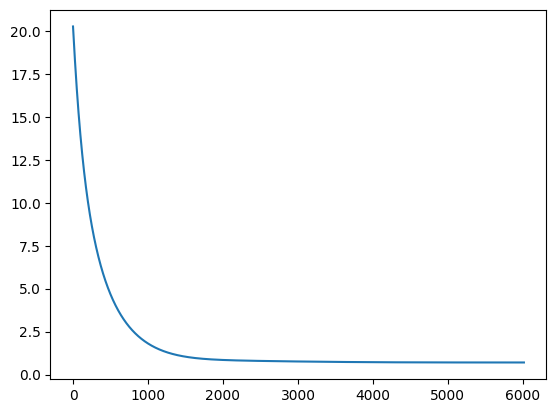

In [6]:
plt.plot(losses)
plt.show()

Lets investigate the $A$-coefficients for one lag in the model as well:

In [7]:
model.A[-1]

Array([[ 0.22896539, -1.1633157 ,  0.36215332],
       [-0.01226423,  1.6473163 , -0.262006  ],
       [-0.502369  , -0.46166694, -0.09152048]], dtype=float32)

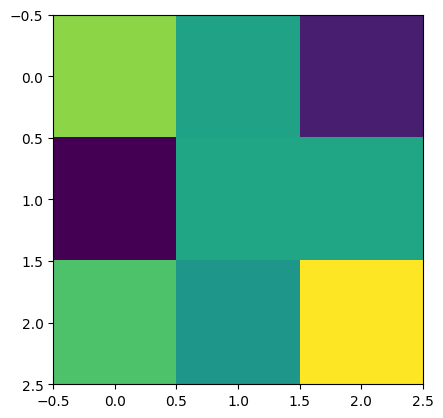

In [8]:
plt.imshow(model.A[0])
plt.show()

## Forecasting with the model
The lagged forecast iterates of the last lags and generate a forecast $horizon$ steps in the future. The last forecast will be recorded and visually compared with the actual data. This is a good way to determine the predictability of a model at different settings of $horizon$, in a visual way. 

In [9]:
horizon = 1
Y_forecast = model.lagged_forecast(Y, horizon, X)
dfz_forecast = pd.DataFrame(Y_forecast, index=df.index, columns=endog_cols)
dfz_forecast[exog_cols] = dfz[exog_cols]

Lets bring the data back to a standard scale:

In [10]:
df_forecast = (dfz_forecast * sigma) + mu

We create a plot to visually compare the forecasts:

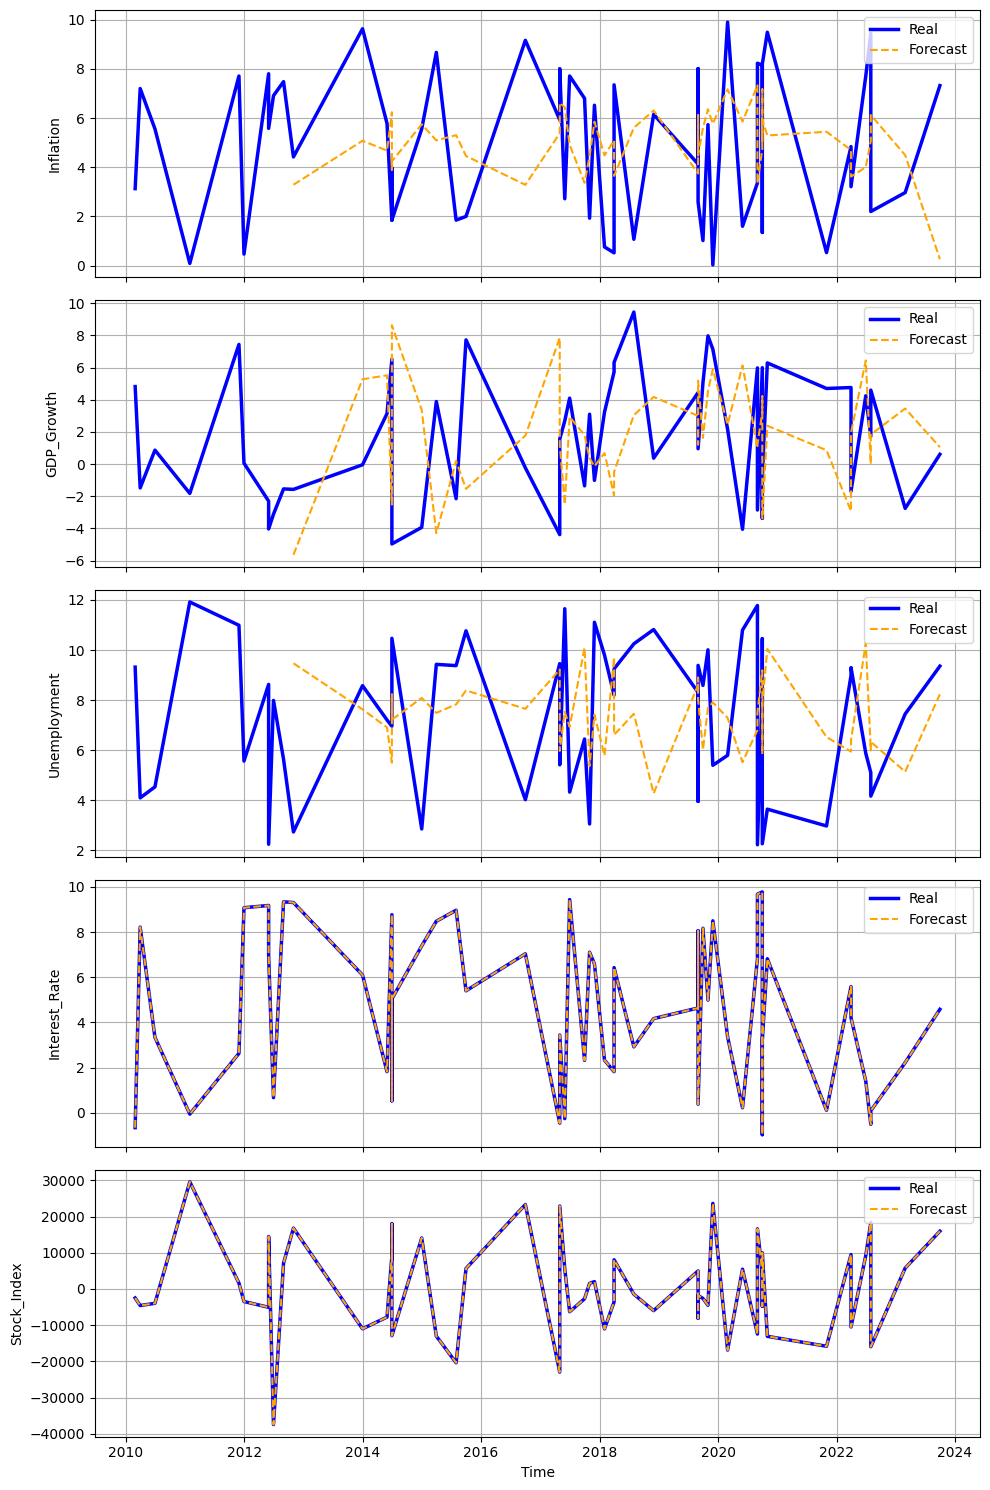

In [11]:
num_columns = len(df.columns)
fig, axes = plt.subplots(num_columns, 1, figsize=(10, 3 * num_columns), sharex=True)

# Ensure axes is iterable
if num_columns == 1:
    axes = [axes]

for i, col in enumerate(df.columns):
    ax = axes[i]
    ax.plot(df.index, df[col], label='Real', color='blue', linewidth=2.5)
    ax.plot(df_forecast.index, df_forecast[col], label='Forecast', color='orange', linestyle='--')
    ax.set_ylabel(col)
    ax.legend(loc='upper right')
    ax.grid(True)

axes[-1].set_xlabel('Time')

fig.tight_layout()
plt.show()

Feel free to experiment with both the data, lags and wich signals to include in a model (this model result is as you see not very well formulated).